In [1]:
try:
  import unidecode
except ModuleNotFoundError:
  !pip install pyogrio==0.7.2 geopandas==0.14.3 unidecode

In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
from IPython.core.magic import register_cell_magic
from glob import glob
import numpy as np
from unidecode import unidecode
from google.colab import drive
import ee
import geemap.foliumap as geemap
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

In [3]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

@register_cell_magic
def skip(line, cell):
    return



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Basic farm information

In [4]:
path = "/content/drive/MyDrive/CAFO_data/South_Africa/"
df = pd.read_csv(f"{path}SouthAfrica_N2P.csv")

df['Latitude'] = df["Latitude, longitude"].str.split(",").str[0].astype(float)
df['Longitude'] = df["Latitude, longitude"].str.split(",").str[1].astype(float)

farms = gpd.GeoDataFrame(df, geometry=\
                       gpd.points_from_xy(df["Longitude"], df["Latitude"],\
                                          crs="EPSG:4326"))

farms = farms[["geometry", "Region", "Number", "Info"]]\
         .rename(columns={"Number": "Number of animals"})

print(f"The smallest farm has {farms['Number of animals'].min()} pigs")
print(f"The largest farm has {farms['Number of animals'].max()} pigs")

The smallest farm has 3600 pigs
The largest farm has 60000 pigs


In [5]:
# Step through the farms on a map

def loop_over_buildings(to_check):
  os.environ["HYBRID"] = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'

  viz = {
      'color': 'yellow',
      'width': 2,
      'fillColor': '00000000'
  }

  false_positives = []
  for n in range(len(to_check)):
    feature = gpd.GeoDataFrame(to_check.iloc[n]).T.set_geometry('geometry')\
                                .set_crs("EPSG:4326")

    print(f"Working on feature {n} of {len(to_check)}")
    display(feature)
    fc = geemap.geopandas_to_ee(feature[['geometry']])

    Map = geemap.Map()
    Map.centerObject(fc.first().geometry(), 17)
    Map.add_basemap("HYBRID")
    Map.addLayer(fc, viz, "Not-farms")
    display(Map)

    response = input("Enter keep to keep, reject to reject, exit to exit  ")
    if response == 'reject':
      false_positives.append(feature.index[0])
    if response == 'exit':
      break

  return false_positives

_ = loop_over_buildings(farms[farms.index.isin([12])])

Working on feature 0 of 1


,geometry,Region,Number of animals,Info
12,POINT (21.28325 -34.13422),Western Cape,13500,Riversdale Piggery


Enter keep to keep, reject to reject, exit to exit  k


In [6]:
# Get ADM1-level boundaries. For some reason there are only polygons in these
# shapefiles, and no province names (!)

boundaries = gpd.read_file(f"{path}shapefiles/zaf_admbnda_adm1_sadb_ocha_20201109.shp").\
             set_crs("EPSG:4326")

In [7]:
min_building_size = 200

In [8]:
%%skip

# Skip this cell unless there's some reason to recreate the building file, e.g
# if min_building_size has changed. Read the existing file in the next cell
# instead

for index, name in zip([0, 8], ["EasternCape", "WesternCape"]):
  province = gpd.GeoDataFrame(boundaries.iloc[index].to_frame().T).set_crs("EPSG:4326")
  geom = geemap.geopandas_to_ee(province)
  buildings_fc = (
      ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/ZAF")
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
      .filterBounds(geom)
  )

  utils.write_to_file(buildings_fc, f"{name}_buildings_{min_building_size}_sq_m",\
                      'South_Africa')

utils.ee_task_status()

In [9]:
%%time
# Read the data into a geodataframe (takes about 1.5 mins, 570,000 buildings)

gdf1 = gpd.read_file(f"{path}WesternCape_buildings_{min_building_size}_sq_m.geojson")
gdf2 = gpd.read_file(f"{path}EasternCape_buildings_{min_building_size}_sq_m.geojson")

buildings = pd.concat([gdf1, gdf2], ignore_index=True)
buildings.rename(columns={"area_in_meters": "Area (sq m)"}, inplace=True)
print(f"There are {len(buildings)} buildings > {min_building_size} sq m")

There are 570267 buildings > 200 sq m
CPU times: user 1min 9s, sys: 2.53 s, total: 1min 12s
Wall time: 1min 17s


In [10]:
# Find all the buildings that are within <farm_dist> m of a farm, and those
# that are more than <not_farm_dist> away

crs = "EPSG:2055"
farm_dist = 150
not_farm_dist = 1000
farm_buildings, other_buildings = explore.join_farms_and_buildings(farms,\
                                                                  buildings,\
                                                                  farm_dist,\
                                                                  not_farm_dist,\
                                                                  crs)

print(f"There are {len(farm_buildings)} buildings within {farm_dist} m of farm coords ")
print(f"There are {len(other_buildings)} buildings >{not_farm_dist} m from\
 farm coords (any farm type) ")

There are 284 buildings within 150 m of farm coords 
There are 569353 buildings >1000 m from farm coords (any farm type) 


In [11]:
# Calculate the lengths and aspect ratios of those buildings
farm_buildings = explore.get_dimensions(farm_buildings, crs=crs)

In [12]:
# Drop all but the largest building per farm

max_farm_bldgs = farm_buildings.sort_values('Area (sq m)', ascending=False)\
                              .drop_duplicates(['Parent coords'])
print(f"{len(farm_buildings)} buildings --> {len(max_farm_bldgs)} buildings")

temp = farms[farms['Region'].isin(["Eastern Cape", "Western Cape"])]
print(f"Started with {len(temp)} farms in Eastern Cape + Western Cape")

284 buildings --> 21 buildings
Started with 21 farms in Eastern Cape + Western Cape


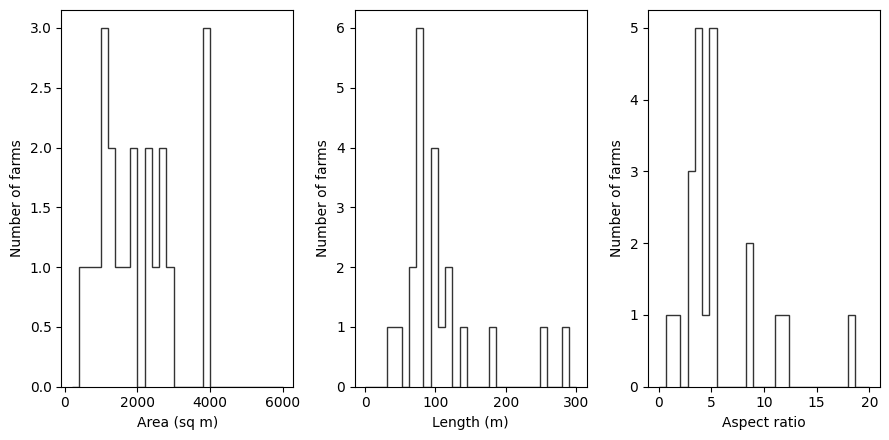

In [19]:
bins = {}
bins['Area (sq m)'] = np.linspace(min_building_size, 6000, 30)
bins['Length (m)'] = np.linspace(0, 300, 30)
bins['Aspect ratio'] = np.linspace(0, 20, 30)

_, axes = plt.subplots(1, 3, figsize=(9, 4.5))
for col, ax in zip(["Area (sq m)", "Length (m)", "Aspect ratio"], axes):
  ax.hist(max_farm_bldgs[col], bins[col], histtype='step', color='0.2')
  ax.set_xlabel(col)
  ax.set_ylabel("Number of farms")

plt.tight_layout()

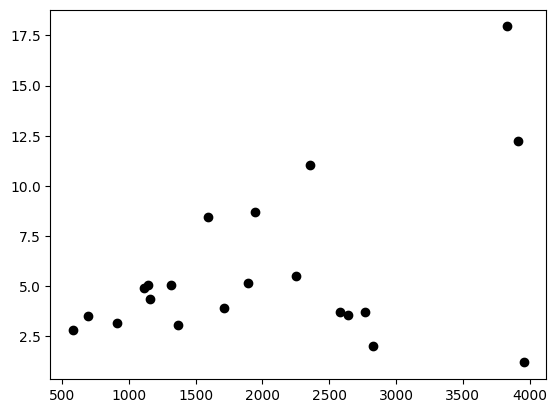

In [13]:
plt.plot(max_farm_bldgs['Area (sq m)'], max_farm_bldgs["Aspect ratio"], "ko")